In [1]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


PARQA= os.getenv('PARQA')

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Reading data

In [16]:
path = PARQA + 'data/311/311_all_full.csv'
df = pd.read_csv(path)

/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (8,17,38,39,40,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
df['Created Date'] = pd.to_datetime(df['Created Date'], format = '%m/%d/%Y %I:%M:%S %p')

In [29]:
df['Closed Date'] = pd.to_datetime(df['Closed Date'], format = '%m/%d/%Y %I:%M:%S %p')

## Numbers

In [38]:
Lcalls = len(df)
dpr = df[df.Agency=='DPR']
Ldpr = len(dpr)
Lparks = len(dpr[~dpr['Location Type'].isin(['Street/Curbside','Street'])])

In [41]:
print Lcalls
print Ldpr
print Lparks

print
print 100.0*Ldpr/Lcalls
print 100.0*Lparks/Ldpr

10030671
459764
81685

4.58358169658
17.7667237974


## Timeline

In [42]:
def plotTimeline(df, ax, ssize='1M', column = 'Created Date', title=None):
    if title:
        df.set_index('Created Date').resample(ssize, how='size').plot(ax=ax, legend=0,c='k', title=title)
    else:
        df.set_index('Created Date').resample(ssize, how='size').plot(ax=ax, c='k', legend=0)

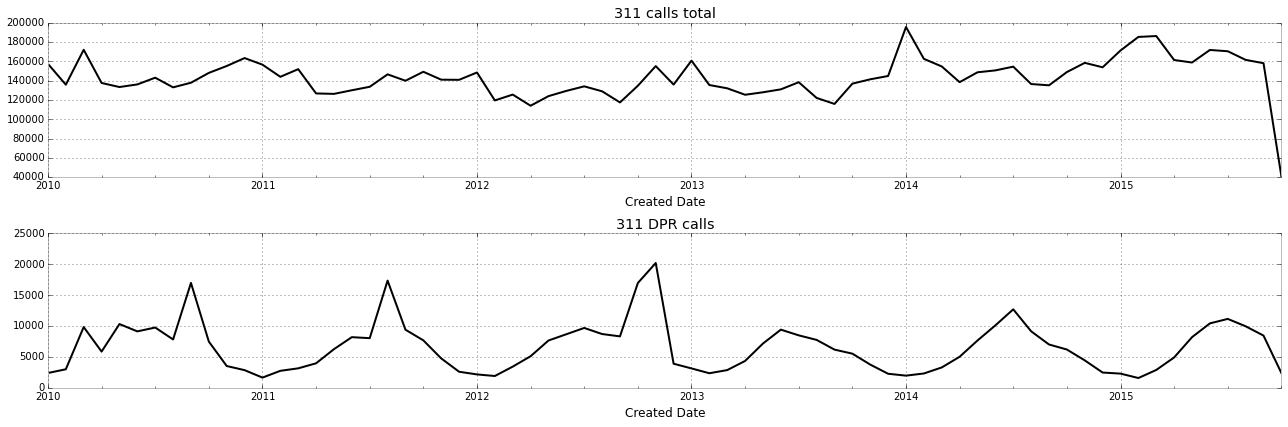

In [53]:
fig,axes = plt.subplots(2, figsize=(18,6))

plotTimeline(df, axes[0], title='311 calls total')
plotTimeline(df[df.Agency=='DPR'], axes[1], title='311 DPR calls')
plt.tight_layout()
plt.savefig(PARQA + 'parqa/311/img/311_exploration_1.png')

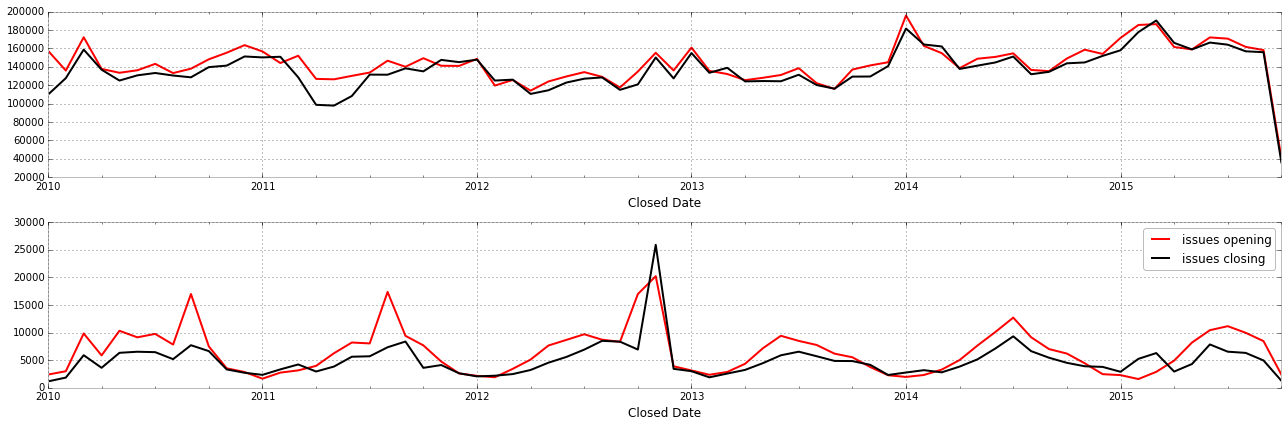

In [48]:
fig,axes = plt.subplots(2, figsize=(18,6))

df.set_index('Created Date').resample('1M', how='size').plot(ax=axes[0], label='issues opening', c='r')
df[(df['Closed Date']>=df['Created Date'].min()) & (df['Closed Date']<=df['Created Date'].max())].set_index('Closed Date').resample('1M', how='size').plot(ax=axes[0], label='issues closing', c='k')


df[df.Agency=='DPR'].set_index('Created Date').resample('1M', how='size').plot(ax=axes[1], label='issues opening', c='r')
df[(df['Closed Date']>=df['Created Date'].min()) & (df['Closed Date']<=df['Created Date'].max()) & (df.Agency=='DPR')].set_index('Closed Date').resample('1M', how='size').plot(ax=axes[1], label='issues closing',c='k')

plt.legend()
plt.tight_layout()
plt.savefig(PARQA + 'parqa/311/img/311_exploration_2.png')

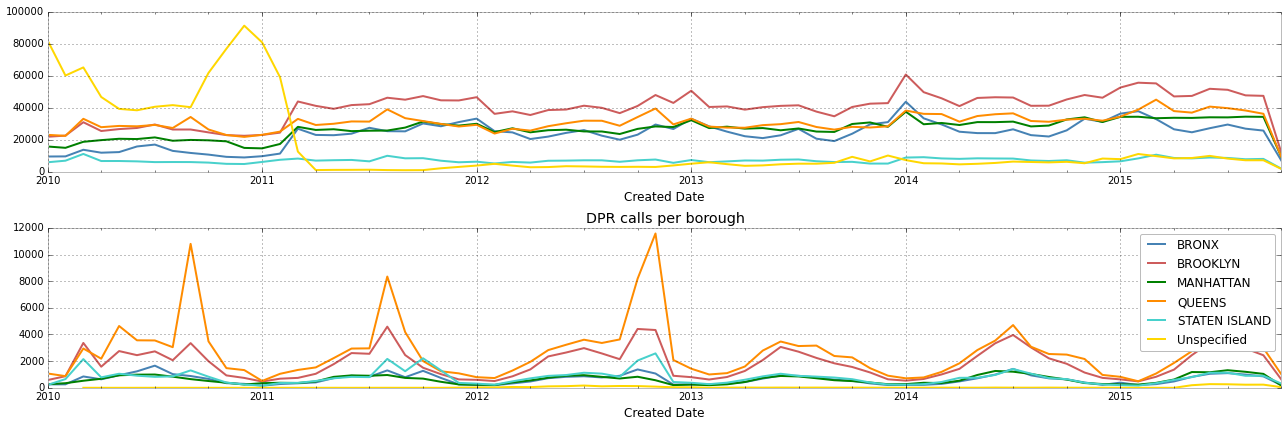

In [57]:
fig, axes = plt.subplots(2, figsize=(18, 6))


for name, g in df.groupby('Park Borough'):
    g = g.set_index('Created Date').resample('1M', how='size').plot(ax=axes[0], label=name)

plt.title('calls per borough')
plt.legend()

for name, g in df[df.Agency == 'DPR'].groupby('Park Borough'):
    g = g.set_index('Created Date').resample('1M', how='size').plot(ax=axes[1], label=name)

plt.title('DPR calls per borough')
plt.legend()

plt.tight_layout()

plt.savefig(PARQA + 'parqa/311/img/exploration3.png')

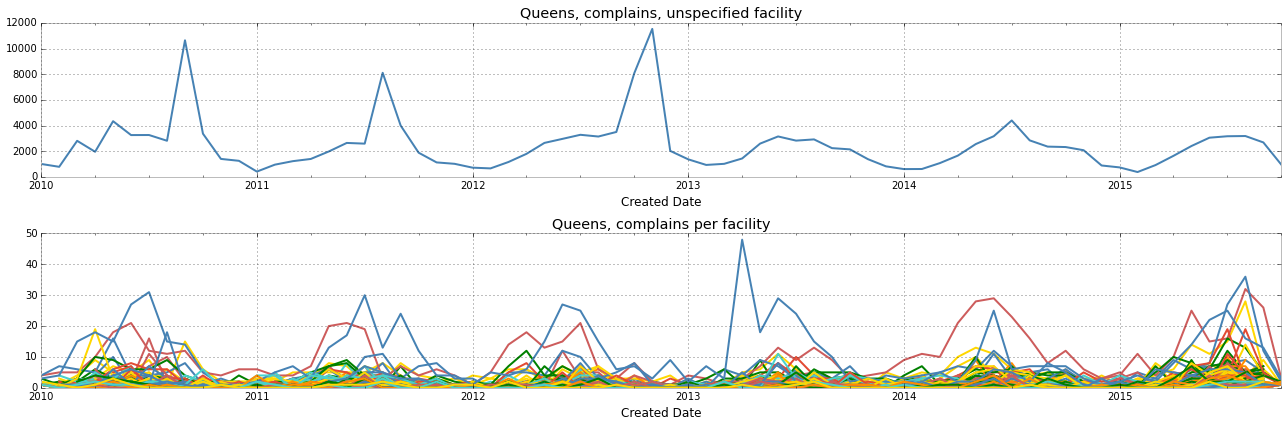

In [66]:
# it does not work to aggregate 
fig, axes = plt.subplots(2, figsize=(18, 6))

df[(df.Agency == 'DPR') & (df['Park Borough']=='QUEENS') & (df['Park Facility Name']=='Unspecified')]\
                    .set_index('Created Date').resample('1M', how='size').plot(ax=axes[0], legend=0)

for name, g in df[(df.Agency == 'DPR') & (df['Park Borough']=='QUEENS') & (df['Park Facility Name']!='Unspecified')].groupby('Park Facility Name'):
    g = g.set_index('Created Date').resample('1M', how='size').plot(ax=axes[1], legend=0)

axes[0].set_title('Queens, complains, unspecified facility')
axes[1].set_title('Queens, complains per facility')

plt.tight_layout()
plt.savefig(PARQA + 'parqa/311/img/exploration4.png')

In [65]:
df[(df.Agency == 'DPR') & (df['Park Borough']=='QUEENS')]['Park Facility Name'].value_counts().head(10)

Unspecified                     173655
Rockaway Beach Boardwalk           754
Flushing Meadows Corona Park       721
Forest Park                        399
Astoria Park                       343
Juniper Valley Park                266
Alley Pond Park                    223
Kissena Park                       201
Cunningham Park                    162
Brookville Park                    139
Name: Park Facility Name, dtype: int64

In [70]:
Q = df[(df.Agency == 'DPR') & (df['Park Borough']=='QUEENS') & (df['Park Facility Name']=='Unspecified')]
# Q.columns
print len(Q)
print len(Q[pd.notnull(Q.Longitude)])

173655
172770


In [77]:
# Q.columns
Q['Location Type'].value_counts()

Street               166628
Park                   4382
Street/Curbside        1003
Recreation Center        25
Pool                     18
Beach                     9
Name: Location Type, dtype: int64

In [79]:
Q.Descriptor.value_counts().head(10)

Branch or Limb Has Fallen Down    34096
Dead/Dying Tree                   25420
Entire Tree Has Fallen Down       18536
Trees and Sidewalks Program       18208
Branch Cracked and Will Fall      17384
Hitting Building                  10498
Tree Leaning/Uprooted              8350
Hitting Power/Phone Lines          8081
Dead Branches in Tree              6375
Blocking Street                    5927
Name: Descriptor, dtype: int64